In [1]:
import sys
sys.path.append('../..')
import torchvision 
from torchvision import transforms
import math
import matplotlib.pyplot as plt
import cox
from cox.utils import Parameters
import cox.store as store
from cox.readers import CollectionReader
import seaborn as sns

from delphi import train
from delphi import cifar_models
from delphi.utils.datasets import CIFAR
from delphi.utils import model_utils, defaults, data_augmentation as da, constants as consts

In [3]:
ds = CIFAR(data_path='/home/pstefanou/')
model, _ = model_utils.make_and_restore_model(arch='resnet50', dataset=ds)
train_loader, val_loader = ds.make_loaders(batch_size=128, workers=8)

ValueError: Missing required args {'data_path'}

# Explore Dataset

label: horse


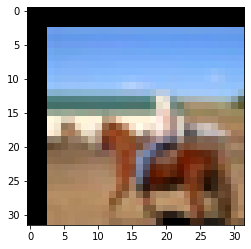

label: cat


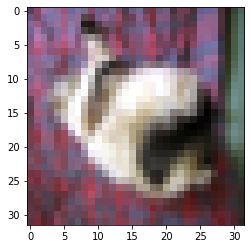

label: airplane


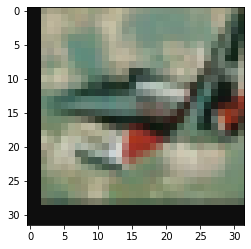

label: dog


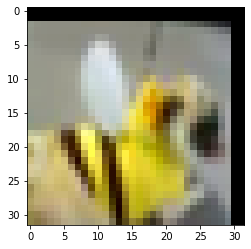

label: deer


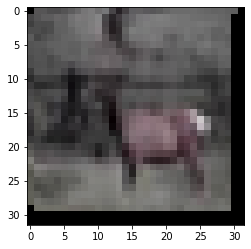

label: frog


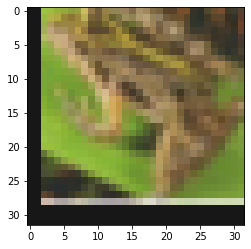

label: truck


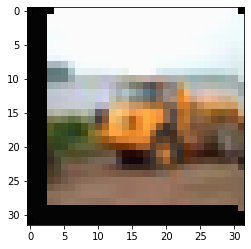

label: bird


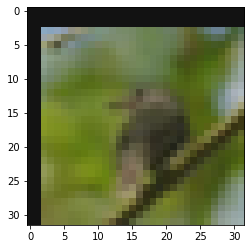

label: automobile


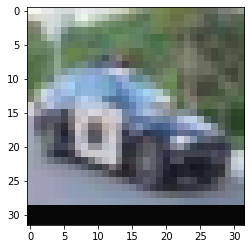

label: ship


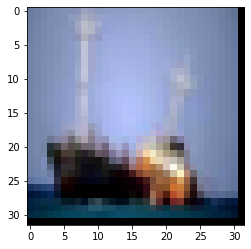

In [5]:
labels = {i for i in range(10)}
for image, target in train_loader: 
    for j in range(len(target)): 
        im, targ = image[j], target[j]
        if targ.item() in labels: 
            print("label: {}".format(da.CIFAR_LABELS[targ.item()]))
            plt.imshow(transforms.ToPILImage(mode="RGB")(im.squeeze(0)))
            plt.show()
            labels.remove(targ.item())
        if len(labels) == 0: 
            break

# Training Arguments

In [8]:
train_kwargs = Parameters({ 
    'lr': 1e-1, 
    'should_save_ckpt': True,
    'out_dir': '/home/pstefanou/cifar-10-resnet50',
    'adv_train': 0,
    'custom_lr_multiplier': consts.COSINE, 
    'device': 'cuda:1'
})
train_args = defaults.check_and_fill_args(train_kwargs, defaults.TRAINING_ARGS, CIFAR)
train_args

{
  "lr": 0.1,
  "should_save_ckpt": true,
  "out_dir": "/home/pstefanou/cifar-10-resnet50",
  "adv_train": 0,
  "custom_lr_multiplier": "cosine",
  "device": "cuda:1",
  "epochs": 150,
  "weight_decay": 0.0005,
  "momentum": 0.9,
  "step_lr": 50,
  "step_lr_gamma": 0.1,
  "lr_interpolation": "step",
  "log_iters": 5,
  "save_ckpt_iters": -1
}

# Train Model

In [ ]:
# logging store
out_store = store.Store(train_args.out_dir)
# model
train.train_model(train_args, model, (train_loader, val_loader), store=out_store, device=train_args.device)

cosine annealing


In [8]:
reader = CollectionReader(train_args.out_dir)
metadata = reader.df('metadata')
logs = reader.df('logs')
reader.close()
logs.head()

100%|██████████| 9/9 [00:00<00:00, 183.48it/s]

new schema missing keys: {'batch_size', 'shuffle', 'validation_split', 'num_workers'}, new keys: {'lr_interpolation', 'adv_train', 'step_lr_gamma', 'step_lr'}
new schema missing keys: {'batch_size', 'shuffle', 'validation_split', 'num_workers'}, new keys: {'lr_interpolation', 'adv_train', 'step_lr_gamma', 'step_lr'}
new schema missing keys: {'batch_size', 'shuffle', 'validation_split', 'num_workers'}, new keys: {'lr_interpolation', 'adv_train', 'step_lr_gamma', 'step_lr'}
new schema missing keys: {'batch_size', 'shuffle', 'validation_split', 'num_workers'}, new keys: {'lr_interpolation', 'adv_train', 'step_lr_gamma', 'step_lr'}
new schema missing keys: {'batch_size', 'shuffle', 'validation_split', 'num_workers'}, new keys: {'lr_interpolation', 'adv_train', 'step_lr_gamma', 'step_lr'}
new schema missing keys: {'batch_size', 'shuffle', 'validation_split', 'num_workers'}, new keys: {'lr_interpolation', 'adv_train', 'step_lr_gamma', 'step_lr'}


,epoch,val_prec1,val_loss,train_prec1,train_loss,time,exp_id
0,1,21.854000,1.961156,16.302000,2.449052,12.604882,41e47676-0d3f-4433-b7c4-9a4008e38662
1,2,30.957998,1.757909,25.462000,1.873939,25.448538,41e47676-0d3f-4433-b7c4-9a4008e38662
2,3,45.531998,1.454303,38.160000,1.608956,38.439981,41e47676-0d3f-4433-b7c4-9a4008e38662
3,4,57.801998,1.166993,50.961998,1.323631,51.247648,41e47676-0d3f-4433-b7c4-9a4008e38662
4,5,63.917999,1.015980,60.427998,1.109508,64.077276,41e47676-0d3f-4433-b7c4-9a4008e38662


# Accuracy and Loss Curves

Text(0.5, 1.0, 'Accuracy Curve')

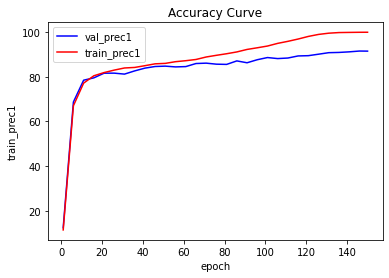

In [13]:
sns.lineplot(data=logs[logs['exp_id'] == '01eb8756-856f-4120-a868-163f280b32c7'], x='epoch', y='val_prec1', label='val_prec1', color='b')
sns.lineplot(data=logs[logs['exp_id'] == '01eb8756-856f-4120-a868-163f280b32c7'], x='epoch', y='train_prec1', label='train_prec1', color='r').set_title('Accuracy Curve')

Text(0.5, 1.0, 'Loss Curve')

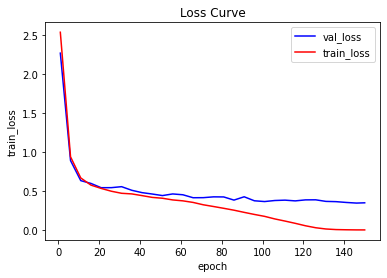

In [14]:
sns.lineplot(data=logs[logs['exp_id'] == '01eb8756-856f-4120-a868-163f280b32c7'], x='epoch', y='val_loss', label='val_loss', color='b')
sns.lineplot(data=logs[logs['exp_id'] == '01eb8756-856f-4120-a868-163f280b32c7'], x='epoch', y='train_loss', label='train_loss', color='r').set_title('Loss Curve')

# Load in Model

In [18]:
model_path = open('/home/pstefanou/cifar-10-vgg11/41e47676-0d3f-4433-b7c4-9a4008e38662/checkpoint.pt.best',"rb")
base_model = cifar_models.__dict__['vgg11'](num_classes=10)
checkpoint_dict = ch.load('/home/pstefanou/cifar-10-vgg11/41e47676-0d3f-4433-b7c4-9a4008e38662/checkpoint.pt.best')
base_model.load_state_dict(checkpoint_dict['model'])

<All keys matched successfully>